<a href="https://colab.research.google.com/github/robotonio/greeneye_sml/blob/main/green_eye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect and authentcate with Google Earth Engine account (do it just the first time)

In [ ]:
#Import earth engine
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=-yGqP8li0kR3tJ6puxDp0FcgEUKPbC2ALNbbb1sFwJs&tc=I7xtYMf2oKddgSgqV73ZnIoAgwxU7dNKgDWrZpKbHHg&cc=qZJTk5r18pEg5M1e5Tap8l9P47E_OlpKvJ9c-ZwYQ3Q

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VOuxYIKiLqsvWvXmgom1VOv0Zfn6Exvfk9EFVb0e4NlYvU9fiDkJ-g

Successfully saved authorization token.


Upload files:


1.   image files you need to process
2.   csv files with the images data (lon/lat etc)*italicized text*



In [ ]:
from google.colab import files

# upload GREENEYE photos 017, 217, 222, 236
# upload LEVELUP photos 016, 023, 083, 088, 337
uploaded = files.upload()

Display the original image you want to process

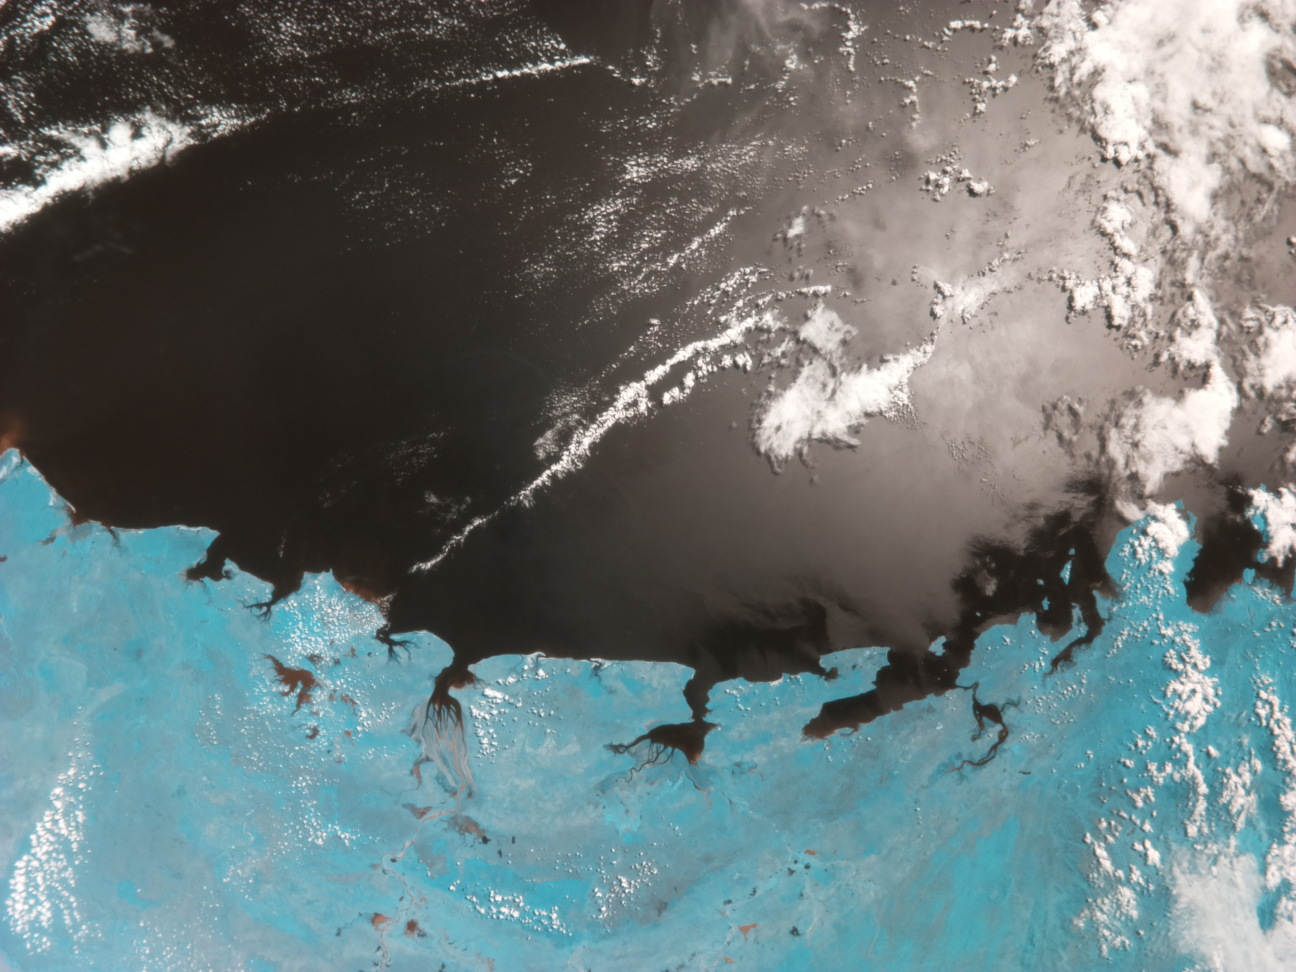

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

image_num = 83
image = cv2.imread(f"photo_{image_num:03d}.jpg")
# resize image
image = cv2.resize(image, (1296, 972), interpolation = cv2.INTER_AREA)
cv2_imshow(image)
cv2.waitKey(0)



Find the longitute and latitude of the image, from the csv file

In [ ]:
import csv

lon = lat = 0
images_data = []
with open('data.csv') as csvfile:
  images_data = csv.reader(csvfile, delimiter=',')

  for img_data in images_data:
    # print(img_data)
    if img_data[0] == str(image_num):
      lon = float(img_data[2]) + 4
      lat = float(img_data[3]) - 4
      break
# lat, lon = 19.801872, -91.433737
print(lat, lon)



44.75872307729728 -13.700542781784389


Find the location and create the ndvi color palette

In [ ]:
geometry = ee.Geometry.Point([lon, lat])

#location = roi.geometry().centroid().coordinates().getInfo()[::-1]
location = geometry.coordinates().getInfo()[::-1]
#Load 2017 Landsat 8
landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')\
.filterDate('2015-01-01', '2015-12-31')\
.median()

# Compute NDVI
ndvi = landsat.normalizedDifference(['B4', 'B3'])

NDVI_Palette = 'FF0000', 'FFFF00', '000000'




Display the google maps image, with the NDVI layer

In [ ]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map object.
my_map = folium.Map(location=[lon, lat], zoom_start = 9)
# Display
my_map.add_ee_layer(ndvi, {'min': -0.3, 'max': 0.5, 'palette': NDVI_Palette}, 'NDVI')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())
# Display the map.


Save the map as html file

In [ ]:
image_path = f"nigeria_{image_num}.html"  # Replace "/path/to/map.png" with the desired path and filename for the image
my_map.save(image_path)
